In [4]:
# %matplotlib inline
from numpy.random import RandomState
import numpy
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import string
from sklearn.decomposition import TruncatedSVD

In [5]:
import os
path_to_model = 'C:/Users/prana/Desktop/BE Project/LegalBuddyServer/OPPClassifiers/SecondaryClassifiers/Models/FirstPartyCollection/PersonalInformationType.sav'
# os.listdir(path_to_model)

# Create Multilabel Dataset

In [6]:
#preprocess
df = pd.read_csv('dataset.csv')
df = df.dropna()

classes = list(df.Category.unique())
total_unique_clauses = df.Clause.unique().size

#creating dict for appending
classes_dict = {}
for single_class in classes:
    classes_dict[single_class] = list(numpy.zeros(total_unique_clauses))

#creating the df
data = {}
for index,row in df.iterrows():
    try : 
        data[row['Clause']].append(row['Category'])
        data[row['Clause']] = list(set(data[row['Clause']]))  
    except:
        data[row['Clause']] = [row['Category']]

        Clause = []
Category = []
for key in data.keys():
    Clause.append(key)
    Category.append(data[key])
    
data = pd.DataFrame({
    'Clause' : Clause,
    'Category' : Category
})
index = 0
for category_list in data.Category:
    for category in category_list:
        classes_dict[category][index] = 1
    index += 1

classes_dict = pd.DataFrame(classes_dict)

In [7]:
data.head()

,Clause,Category
0,Protocol,[IP address and device IDs]
1,"browser types, domain names,",[Computer information]
2,anonymous statistical data regarding your use ...,[User online activities]
3,names,[Contact]
4,addresses,"[Location, Contact]"


In [8]:
classes_dict.head()

,IP address and device IDs,Computer information,User online activities,Contact,Location,Unspecified,Cookies and tracking elements,Generic personal information,Demographic,User profile,Financial,Social media data,Other,Personal identifier,Health,Survey data
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
one_hot_encoded_data = pd.concat([data, classes_dict], axis=1)
one_hot_encoded_data.drop(columns=['Category']).to_csv('multilabel_dataset.csv')

In [10]:
df = pd.read_csv('multilabel_dataset.csv')
df = df.dropna()
train = df.sample(frac=0.8, random_state = RandomState())
test = df.loc[~df.index.isin(train.index)]
validation = train.sample(frac=0.2, random_state=200)

In [11]:
df.columns.values[2:]

array(['IP address and device IDs', 'Computer information',
       'User online activities', 'Contact', 'Location', 'Unspecified',
       'Cookies and tracking elements', 'Generic personal information',
       'Demographic', 'User profile', 'Financial', 'Social media data',
       'Other', 'Personal identifier', 'Health', 'Survey data'],
      dtype=object)

# Visualizing Data

In [12]:
counts = []
categories = list(df.columns.values[2:])
for i in categories:
    counts.append((i, df[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,IP address and device IDs,246.0
1,Computer information,287.0
2,User online activities,544.0
3,Contact,533.0
4,Location,174.0
5,Unspecified,524.0
6,Cookies and tracking elements,393.0
7,Generic personal information,197.0
8,Demographic,139.0
9,User profile,139.0


Text(0.5, 0, 'category')

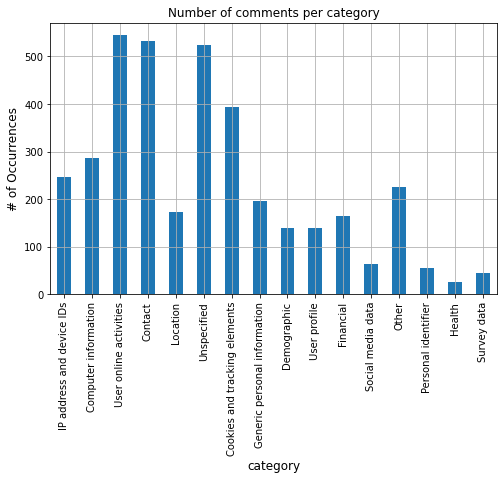

In [13]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

# Preprocessing Data

In [14]:
# cleaned_clause = []
# for clause in df.Clause:
#     clause = clause.lower()
#     clause = re.sub(r'[0-9]+', '',clause) #number removal
#     clause = clause.translate(string.maketrans(“”,””), string.punctuation) #removinf punctuations
#     clause = clause.strip() #whitespace removal
#     clause
#     break

In [15]:
x_test = test.Clause
x_train = train.Clause

In [16]:
y = train.iloc[:,2:]
y_test = test.iloc[:,2:]

categories = list(y.columns)

In [17]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(df.Clause)

<3620x2477 sparse matrix of type '<class 'numpy.float64'>'
	with 39380 stored elements in Compressed Sparse Row format>

# Naive Bayes

In [18]:
prediction_pd = {}
classifier_list_nb = []
for category in categories:
    clf = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_nb.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing IP address and device IDs
Test accuracy is 0.9502762430939227
... Processing Computer information
Test accuracy is 0.9516574585635359
... Processing User online activities
Test accuracy is 0.8977900552486188
... Processing Contact
Test accuracy is 0.9419889502762431
... Processing Location
Test accuracy is 0.9571823204419889
... Processing Unspecified
Test accuracy is 0.8729281767955801
... Processing Cookies and tracking elements
Test accuracy is 0.9654696132596685
... Processing Generic personal information
Test accuracy is 0.9488950276243094
... Processing Demographic
Test accuracy is 0.9779005524861878
... Processing User profile
Test accuracy is 0.9530386740331491
... Processing Financial
Test accuracy is 0.9723756906077348
... Processing Social media data
Test accuracy is 0.9723756906077348
... Processing Other
Test accuracy is 0.93646408839779
... Processing Personal identifier
Test accuracy is 0.9917127071823204
... Processing Health
Test accuracy is 0.9944751381

array([[[673,   0],
        [ 36,  15]],

       [[667,   0],
        [ 35,  22]],

       [[601,   3],
        [ 71,  49]],

       [[609,   4],
        [ 38,  73]],

       [[690,   0],
        [ 31,   3]],

       [[610,   3],
        [ 89,  22]],

       [[663,   2],
        [ 23,  36]],

       [[687,   0],
        [ 37,   0]],

       [[704,   0],
        [ 16,   4]],

       [[690,   0],
        [ 34,   0]],

       [[692,   0],
        [ 20,  12]],

       [[704,   0],
        [ 20,   0]],

       [[678,   0],
        [ 46,   0]],

       [[718,   0],
        [  6,   0]],

       [[720,   0],
        [  4,   0]],

       [[713,   0],
        [ 11,   0]]], dtype=int64)

# Linear SVC

In [19]:
prediction_pd = {}
classifier_list_svc = []
clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
for category in categories:
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_svc.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing IP address and device IDs
Test accuracy is 0.9875690607734806
... Processing Computer information
Test accuracy is 0.9751381215469613
... Processing User online activities
Test accuracy is 0.9392265193370166
... Processing Contact
Test accuracy is 0.9779005524861878
... Processing Location
Test accuracy is 0.988950276243094
... Processing Unspecified
Test accuracy is 0.9185082872928176
... Processing Cookies and tracking elements
Test accuracy is 0.9875690607734806
... Processing Generic personal information
Test accuracy is 0.9668508287292817
... Processing Demographic
Test accuracy is 0.9917127071823204
... Processing User profile
Test accuracy is 0.9654696132596685
... Processing Financial
Test accuracy is 0.9930939226519337
... Processing Social media data
Test accuracy is 0.9848066298342542
... Processing Other
Test accuracy is 0.93646408839779
... Processing Personal identifier
Test accuracy is 0.9930939226519337
... Processing Health
Test accuracy is 0.99861878453

array([[[670,   3],
        [  6,  45]],

       [[660,   7],
        [ 11,  46]],

       [[592,  12],
        [ 32,  88]],

       [[611,   2],
        [ 14,  97]],

       [[689,   1],
        [  7,  27]],

       [[590,  23],
        [ 36,  75]],

       [[662,   3],
        [  6,  53]],

       [[682,   5],
        [ 19,  18]],

       [[703,   1],
        [  5,  15]],

       [[687,   3],
        [ 22,  12]],

       [[692,   0],
        [  5,  27]],

       [[702,   2],
        [  9,  11]],

       [[667,  11],
        [ 35,  11]],

       [[718,   0],
        [  5,   1]],

       [[720,   0],
        [  1,   3]],

       [[712,   1],
        [  4,   7]]], dtype=int64)

# Logistic Regression

In [20]:
prediction_pd = {}
classifier_list_lr = []
clf = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)
for category in categories:
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_lr.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing IP address and device IDs
Test accuracy is 0.9792817679558011
... Processing Computer information
Test accuracy is 0.9668508287292817
... Processing User online activities
Test accuracy is 0.9226519337016574
... Processing Contact
Test accuracy is 0.9640883977900553
... Processing Location
Test accuracy is 0.9751381215469613
... Processing Unspecified
Test accuracy is 0.9019337016574586
... Processing Cookies and tracking elements
Test accuracy is 0.9820441988950276
... Processing Generic personal information
Test accuracy is 0.9682320441988951
... Processing Demographic
Test accuracy is 0.9834254143646409
... Processing User profile
Test accuracy is 0.9571823204419889
... Processing Financial
Test accuracy is 0.9820441988950276
... Processing Social media data
Test accuracy is 0.9751381215469613
... Processing Other
Test accuracy is 0.93646408839779
... Processing Personal identifier
Test accuracy is 0.9917127071823204
... Processing Health
Test accuracy is 0.9944751381

array([[[673,   0],
        [ 15,  36]],

       [[666,   1],
        [ 23,  34]],

       [[599,   5],
        [ 51,  69]],

       [[611,   2],
        [ 24,  87]],

       [[690,   0],
        [ 18,  16]],

       [[607,   6],
        [ 65,  46]],

       [[664,   1],
        [ 12,  47]],

       [[686,   1],
        [ 22,  15]],

       [[704,   0],
        [ 12,   8]],

       [[690,   0],
        [ 31,   3]],

       [[692,   0],
        [ 13,  19]],

       [[704,   0],
        [ 18,   2]],

       [[678,   0],
        [ 46,   0]],

       [[718,   0],
        [  6,   0]],

       [[720,   0],
        [  4,   0]],

       [[713,   0],
        [ 10,   1]]], dtype=int64)

In [21]:
import pickle
#saving model
list_of_classifiers = classifier_list_lr
pickle.dump((tfidf, list_of_classifiers), open(path_to_model, 'wb'))

In [22]:
with open(path_to_model, 'rb') as model:
    vect, clfs = pickle.load(model)

In [16]:
clfs

[OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                  dual=False, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=None, max_iter=100,
                                                  multi_class='auto',
                                                  n_jobs=None, penalty='l2',
                                                  random_state=None,
                                                  solver='sag', tol=0.0001,
                                                  verbose=0, warm_start=False),
                     n_jobs=1),
 OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                  dual=False, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=